# CPS 491 Main Jupyter Notebook

Author: Zachary Rowland

Contents

* [Python Imports](#Python-Imports) Python imports for the whole document
* [Linear Systems Background](#Linear-Systems-Background) Brief overview of core concepts and vocabulary from Linear Systems and signals analysis
* [Using Tensorflow](#Using-Tensorflow) Quick reference and code examples for using Tensorflow
* [Approximations](#Approximations) Mathematical background and implementation detailing how to approximate simple functions using neural networks.
  * [Approximating $x^2$](#Approximating-the-Square-Function) Shows how a neural network can approximate a square function to arbitrary precision.
  * [Approximating](#Approximating-General-Powers) Generalizing the approximation of $x^2$ to arbitrary powers of $x$.
* [Approximating an Arbitrary Function using Convolution](#Approximating-an-Arbitrary-Function-using-Convolution) A method for approximating an arbitrary function inspired by convolution.
  * [Theory and Method](#Theory-and-Method)
  * [Implementation](#Implementation) Example code for approximating a function $f$.
  * [4-Layer Version](#Four-Layer-Version) Allows sigmoid-like activation functions to be used instead of "spike" or gaussian curve activations.

[Tensorflow Guide](https://www.tensorflow.org/guide/)


# Python Imports

These are just global imports that are used by the whole document. Run the following cell before running anything else.

In [ ]:
import math
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import graphviz as gv
import tensorflow as tf

---

# Linear Systems Background

Some vocabulary:

* **Def** A _signal_ (denoted with $x$ or $y$) just refers to a real-valued function (usually over time). Alternatively, it can be thought of as a list of (output) values.
* **Def** _Shifted signal_: $x \Rsh s$ is the signal such that $(x \Rsh s)(t) = x(t - s)$. Usually, $x(t - s)$ denotes the shifted signal itself, but using the denotation $\Rsh$ clarifies that shifting is an operation on a signal. 
* **Def** A _system_ or _transform_ (denoted $T$) is a "function on functions", a transformation from one signal to another.
* **Def** A _linear system_ is a system that satisfies homogeneity and additivity from linear algebra.
* **Def** A _shift-invariant system_ $T$ satisfies the property $T[x \Rsh s] = T[x] \Rsh s$ for any signal and shift amount.
* **Def** The _unit impulse_ signal (denoted $\delta(t)$) is a spike at time zero and is defined such that:
$$ \int_{-\infty}^{t} \delta(\tau)\ d\tau = \begin{cases} 0 \qquad t < 0 \\ 1 \qquad t > 0 \end{cases}$$

Any signal can be represented as a linear combination of shifted and scaled impulse signals:
$$ x(t) = \int_{-\infty}^{\infty} x(\tau)\ \delta(t - \tau)\ d\tau $$

Suppose $T$ is a linear shift-invariant transform. Then, by properties of linearity and shift-invariance:
$$ T[x(t)] = \int_{-\infty}^{\infty} x(\tau)\ (T[\delta])(t - \tau) \ d\tau $$
This means that $T$ is completely characterized by how it maps the unit impulse signal. $T[\delta]$ is called the _impulse response signal_.

**Def** A _convolution_ is a combination of two signals. We say $x * y$ is the result of convolving $x$ with $y$.
  $$ (x * y)(t) = \int_{-\infty}^{\infty} x(\tau)\ y(t - \tau)\ d\tau $$
  $$ x * y = \int_{-\infty}^{\infty} x(\tau)\ (y \Rsh \tau)\ d\tau $$
  Think of convolution as constructing a new signal that is a linear combination of a set of base signals. But each base signal is just a shifted version of a single signal $y$. The factors that scale the base signals are the outputs of $x$.

Special Convolutions:
 * $x * \delta = x$
 * $x * 1 = \int_{-\infty}^{\infty} x(\tau)\ d\tau$
 * $x * \text{step} = \int_{-\infty}^{t}x(\tau)\ d\tau \qquad$ ("step" is the integral of $\delta$)



Differentiation on real functions is a shift-invariant linear operation, so it can be expressed as a convolution ($d$ is the "derivative" of $\delta$):
$$ \frac{dx}{dt} = x * d = \int_{-\infty}^{\infty} x(\tau)\ (d \Rsh \tau)\ d\tau $$

A Taylor series is similar to a convolution, but uses a discrete sum instead of the continuous integral.

$$ f(x) = \sum_{n=0}^{\infty} \frac{f^{(n)}(a)}{n!} (x - a)^n \qquad \forall x, a \in \mathbb{R} $$

---

# Using Tensorflow

An brief overview of tensor math and learning models in the Tensorflow library descibed with lots of code examples.

In [ ]:
# generating simple test data

f = open("sin_data.csv", "w")
f.write("x,sin(x)\n")
for i in range(200):
  x = random.random()*2*math.pi
  v = math.sin(x)
  f.write(str(x)+","+str(v)+"\n")
f.close()

In [ ]:
# example loading CSV file into a pandas dataframe
sin_dataframe = pd.read_csv("sin_data.csv", sep=",")  # type is pd.DataFrame
sin_dataframe.head(3)   # returns a new dataframe with only first 3 rows

,x,sin(x)
0,4.813718,-0.994871
1,2.562307,0.547426
2,3.390245,-0.246098


## Tensor Math

The primary objects that Tensorflow provides are tensors -- a generalization of scalars, vectors, and matrices to numerical arrays of arbitrary dimension. Tensors have the following properties:

* **dimension**: the number of layers of nested lists needed to represent the tensor (e.g. a vector is a 1-D tensor, a matrix is a 2-D tensor).
* **shape**: a list of numbers describing the "length" of the tensor in each direction (e.g. matrices all have shape (nrows, ncols)).

In [ ]:
# Tensors
t0 = tf.constant(4)   # a rank-0 tensor (i.e. a scalar)
t1 = tf.constant([1,2,3])   # a rank-1 tensor (i.e. a vector)
t2 = tf.constant([[1,2,3], [4,5,6], [7,8,9]])   # a rank-2 tensor (i.e. a matrix)

# constructing simple tensors
t = tf.zeros([3,2])   # a 3x2 tensor filled with zeros
t = tf.random.uniform([3,2], minval=0, maxval=1)
t = tf.random.normal([3,2], mean=5, stddev=2)
t = tf.eye(4)   # 4x4 identity matrix

t = tf.constant([[1,2], [3,4]], dtype=tf.float32)  # manually specify element type

a = np.array(t)   # convert Tensor to numpy array
t = tf.constant(a)  # convert numpy array to Tensor

# Tensor operations
ta = tf.constant([[1,2],[3,4]], dtype=tf.float32)
tb = tf.constant([[5,6],[7,8]], dtype=tf.float32)
t = ta + tb   # element-wise addition
t = ta * tb   # element-wise multiplication
t = ta @ tb   # "matrix" multiplication
t = tf.reduce_max(ta)   # largest value
t = tf.argmax(ta)       # index of largest value
b = ta == tb            # comparison operators are element-wise

# Tensor shape, rank, dimension, size
t = tf.constant([[1,2,3],[4,5,6]])
shape = t.shape     # [2, 3]
anelem = t[0,0]     # indexing (returns a Tensor)
anelem = t[0][0]    # also indexing
t = tf.reshape(t, (3, 2))   # does not shuffle elements in memory, so cheap


## Automatic Differentiation

A _gradient_ is an operation on a scalar-valued function with a tensor input $f: T \rightarrow \mathbb{R}$. The result of calculating the gradient of a function $\nabla f$ is a tensor of same shape as the input. A _Jacobian_ is the generalization of the gradient to tensor-valued functions. If $f: T_{d_1 \times \dots \times d_n} \rightarrow T_{\delta_1 \times \dots \times \delta_m}$, then $\mathbf{J} f: T_{\delta_1 \times \dots \times \delta_m \times d_1 \times \dots \times d_n}$.

In [ ]:
# Automatic Differentiation & Variables

x = tf.Variable([[1],[2],[3]], name="x", dtype=tf.float32)

# a "tape" is needed to store automatic differentiation values
# call GradientTape with persistent=True if you want to calculate multiple
# gradients or jacobians
with tf.GradientTape() as tape:
  y = tf.constant([[1,1,1], [5,1,0]], dtype=tf.float32) @ x

print(y)
j = tape.jacobian(y, x)   # j[output indeces, input indices]

# j[output indeces][input indices] is the derivative
# of output[output indeces] with respect to input[input indeces]

# For example, j[1,0][2,0] is derivative of second component of y
# with respect to the third component of x

tf.Tensor(
[[6.]
 [7.]], shape=(2, 1), dtype=float32)


## A Linear Neural Network

Note that normally, a linear feed-forward function for one layer is written as $W\vec{x} + \vec{b}$. However in tensorflow, vectors are one-dimentional tensors instead of $n \times 1$ matrices, which means it is slightly easier to define this function as $\vec{x}W^t + \vec{b}$.

In [ ]:
# A 1-input 1-output linear neural network.
class LinearModel(tf.keras.Model):
  def __init__(self, indim, outdim, **kwargs):
    super().__init__(**kwargs)
    self.indim = indim
    self.outdim = outdim
    self.w = tf.Variable(tf.random.normal(shape=(indim, outdim)))
    self.b = tf.Variable(tf.random.normal(shape=(1, outdim)))
  def __call__(self, x, **kwargs):
    return tf.matmul(x, self.w) + self.b

# model and test data
mymodel = LinearModel(1, 1)
mymodel.compile(run_eagerly=False,
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.2),
                loss=tf.keras.losses.mean_squared_error)
x = tf.random.uniform(shape=(1000,1,1), minval=-1, maxval=1)
y = x * 0.5 + tf.random.normal(shape=(1000,1,1), mean=0.3, stddev=0.05)
y_obs = mymodel(x)

In [ ]:
# training

mymodel.fit(x, y, epochs=10, batch_size=1000, verbose=1)
y_obs = mymodel(x)


Epoch 1/10
1/1 [==============================] - 0s 4ms/step - loss: 0.0026
Epoch 2/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0026
Epoch 3/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0026
Epoch 4/10
1/1 [==============================] - 0s 9ms/step - loss: 0.0026
Epoch 5/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0026
Epoch 6/10
1/1 [==============================] - 0s 4ms/step - loss: 0.0026
Epoch 7/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0026
Epoch 8/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0026
Epoch 9/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0026
Epoch 10/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0026


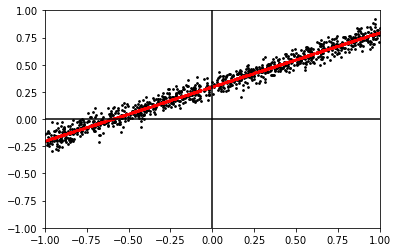

In [ ]:
# show results
plt.ylim(-1, 1)
plt.xlim(-1, 1)
plt.axhline(color="black")
plt.axvline(color="black")
plt.scatter(x, y, c="black", s=3)
plt.scatter(x, y_obs, c="red", s=3)
plt.show()

---

# Approximations

## Approximating the Square Function

Consider any activation function $a(x)$ with a non-zero second-derivative at $x = 0$. This section shows how to construct a neural network using $a$ that can approximate the function $x^2$ with arbitrary accuracy. We start with Taylor's Theorem.

$$ a(x) = \sum_{n = 0}^{\infty} \frac{a^{(n)}(0)}{n!} x^n \qquad \text{(Taylor's Theorem)} $$

First, replace $x$ with $hx$ where $h$ is positive. We will eventually consider what happens when $h$ approaches zero.

$$ a(hx) = \sum_{n = 0}^{\infty} \frac{a^{(n)}(0)}{n!} (hx)^n $$

Now isolate the $x^2$ term on one side.

$$ \frac{h^2 a^{(2)}(0)}{2} x^2 = a(hx) - a(0) - ha'(0)x - \sum_{n=3}^{\infty} \frac{h^n a^{(n)}(0)}{n!} x^n $$

Isolate $x^2$

$$ x^2 = \frac{2a(hx)}{h^2 a^{(2)}(0)} - \frac{2a(0)}{h^2 a^{(2)}(0)} - \frac{2a'(0)x}{h a^{(2)}(0)} - \frac{2}{h^2 a^{(2)}(0)}\sum_{n=3}^{\infty} \frac{h^n a^{(n)}(0)}{n!} x^n $$

If we consider the limit as $h \rightarrow 0$, the sum term drops out because $h^n / h^2$ will always approach zero for any $h \ge 3$. We are left with the following:

$$ x^2 = \lim_{h \rightarrow 0} \left( \frac{2}{h^2 a^{(2)}(0)}a(hx) - \frac{2a(0)}{h^2 a^{(2)}(0)} - \frac{2a'(0)}{h a^{(2)}(0)}x \right) $$

We can simplify by defining three constants (these constants will end up being two weights and a bias for the last layer of a neural network):

$$ x^2 = \lim_{h \rightarrow 0} \left( Aa(hx) - B - Cx \right) $$

$$ A = \frac{2}{h^2 a^{(2)}(0)} \qquad B = Aa(0) \qquad C = Aha'(0) $$



## Approximating General Powers

The process for approximating $x^2$ can be repeated, this time for a general degree $d$. This time, we require that $a^{(d)}(0) \neq 0$. From Taylor's Theorem, isolate the desired power on the left. The $n$ in the sum iterates from zero to infinity, but skips $d$.

$$ x^d = \frac{d!a(hx)}{h^d a^{(d)}(0)} - \frac{d!}{h^d a^{(d)}(0)}\sum_{n\neq d} \frac{h^n a^{(n)}(0)}{n!} x^n $$

Once again, consider the limit as $h \rightarrow 0$. All of the terms in the sum where $n > d$ are going to approach zero leaving us with a finite sum.

$$ x^d = \lim_{h \rightarrow 0} \left( \frac{d!}{h^d a^{(d)}(0)} a(hx) - \sum_{n = 0}^{d - 1} \frac{d! h^{n-d} a^{(n)}(0)}{n! a^{(d)}(0)} x^n \right) $$

Introduce constants:

$$ x^d = \lim_{h \rightarrow 0} \left( A a(hx) - \sum_{n = 0}^{d - 1} B_n x^n \right) $$

$$ A = \frac{d!}{h^d a^{(d)}(0)} \qquad B_n = A h^n a^{(n)}(0) $$

## Approximating Multiplication

This section is old and needs to be upated with documentation and to more closely align with the math described to approximate $x^2$.

In [ ]:
class MultModel(tf.keras.Model):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    self.w1 = tf.Variable(tf.random.uniform(shape=(2, 4), minval=-1, maxval=1))
    self.w2 = tf.Variable(tf.random.uniform(shape=(4,1)))
  def __call__(self, x, **kwargs):
    interm = tf.nn.sigmoid(tf.matmul(x, self.w1) - 0.2)
    return tf.matmul(interm, self.w2)

# model and test data
mymodel = MultModel()
mymodel.compile(run_eagerly=False,
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                loss=tf.keras.losses.mean_squared_error)
x = tf.random.uniform(shape=(1000,1,2), minval=-1.0, maxval=1.0)
y = tf.map_fn(fn=lambda t: tf.constant(t[0,0]*t[0,1], shape=(1,1)), elems=x)
y_obs_0 = mymodel(x)


In [ ]:
# manually set weights
lb = 0.001 # lambda
mu = 1.0/(4*0.2475*lb*lb)
mymodel.w1 = tf.Variable(tf.constant([[lb, lb, -lb, -lb], [lb, -lb, lb, -lb]]))
mymodel.w2 = tf.Variable(tf.constant([[mu], [-mu], [-mu], [mu]]))

In [ ]:
# training

mymodel.fit(x, y, epochs=10, batch_size=1000, verbose=1)
y_obs_1 = mymodel(x)

Epoch 1/10
1/1 [==============================] - 0s 261ms/step - loss: 0.0941
Epoch 2/10
1/1 [==============================] - 0s 5ms/step - loss: 2698417012736.0000
Epoch 3/10
1/1 [==============================] - 0s 3ms/step - loss: 4056183209984.0000
Epoch 4/10
1/1 [==============================] - 0s 5ms/step - loss: 4040029372416.0000
Epoch 5/10
1/1 [==============================] - 0s 4ms/step - loss: 4023937925120.0000
Epoch 6/10
1/1 [==============================] - 0s 3ms/step - loss: 4007911489536.0000
Epoch 7/10
1/1 [==============================] - 0s 5ms/step - loss: 3991950327808.0000
Epoch 8/10
1/1 [==============================] - 0s 4ms/step - loss: 3976051294208.0000
Epoch 9/10
1/1 [==============================] - 0s 5ms/step - loss: 3960218058752.0000
Epoch 10/10
1/1 [==============================] - 0s 7ms/step - loss: 3944445378560.0000


1985972.375


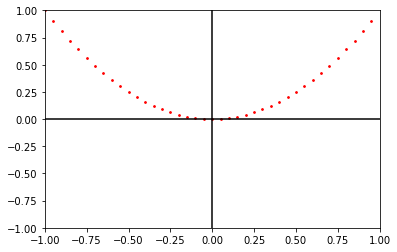

In [ ]:
# examine x**2 function
def mysquare(inp):
  inp = tf.constant([[inp, inp]])
  out = mymodel(inp)
  return float(out)

print(mysquare(1.0))

in_list = tf.range(-1.0, 1.0, 0.05)
out_list_1 = [mysquare(float(t)) for t in in_list]
out_list_2 = in_list * in_list
myplot(in_list, [out_list_1, out_list_2])

## Stacking ReLUs

Experimenting with approximating a function using small ReLU networks.

In [ ]:
# MyModel(numHL, hlWidth) builds a network with one input, one output and numHL
# hidden layers. There must be at least one hidden layer. Each hidden layer
# contains hlWidth nodes. The network is fully connected.
class MyModel(tf.keras.Model):
  def __init__(self, numHL, hlWidth, **kwargs):
    super().__init__(**kwargs)
    # build weights
    self.w = [0.0]*(numHL + 1)
    self.w[0] = tf.Variable(tf.random.uniform(shape=[1, hlWidth], minval=-0.1, maxval=0.1))
    self.w[numHL] = tf.Variable(tf.random.uniform(shape=[hlWidth,1], minval=-0.1, maxval=0.1))
    for i in range(1, numHL):
      self.w[i] = tf.Variable(tf.random.uniform(shape=[hlWidth, hlWidth], minval=0.1, maxval=0.1))
    # build biases
    self.b = [0.0]*(numHL + 1)
    self.b[numHL] = tf.Variable(tf.constant([[0.1]]))
    for i in range(0, numHL):
      self.b[i] = tf.Variable(tf.fill((1, hlWidth), 0.1))
  def __call__(self, x, **kwargs):
    interm = x
    for w, b in zip(self.w[:-1], self.b[:-1]):
      interm = tf.nn.relu(tf.matmul(interm, w) + b)
    return tf.matmul(interm, self.w[-1]) + self.b[-1]

In [ ]:
# make a new random model
reluModel = MyModel(1, 2)

In [ ]:
# manually set weights/biases
reluModel.w[0].assign(tf.constant([[0.8, -1.0]]))
reluModel.b[0].assign(tf.constant([[-1.0, 1.0]]))
reluModel.w[1].assign(tf.constant([[-1.0], [-1]]))
reluModel.b[1].assign(tf.constant([[1.0]]))

<tf.Variable 'UnreadVariable' shape=(1, 1) dtype=float32, numpy=array([[1.]], dtype=float32)>

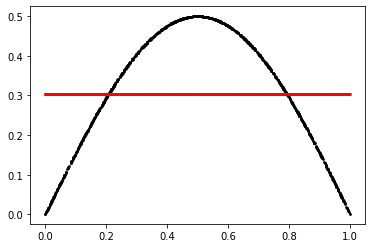

In [ ]:
# Test: plot the model approximation and the actual function f
x = tf.random.uniform((1000, 1, 1), minval=0.0, maxval=1.0)
y = 0.5 * tf.sin(x * math.pi)
y_obs = reluModel(x)
plt.scatter(x, y, c="black", s=3)
plt.scatter(x, y_obs, c="red", s=3)
plt.show()

In [ ]:
# Train the model
reluModel.compile(run_eagerly=False,
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.5),
                loss=tf.keras.losses.mean_squared_error)
reluModel.fit(x, y, epochs=10, batch_size=100, verbose=1)

Epoch 1/10
10/10 [==============================] - 0s 2ms/step - loss: 0.0215
Epoch 2/10
10/10 [==============================] - 0s 1ms/step - loss: 0.0225
Epoch 3/10
10/10 [==============================] - 0s 2ms/step - loss: 0.0235
Epoch 4/10
10/10 [==============================] - 0s 2ms/step - loss: 0.0225
Epoch 5/10
10/10 [==============================] - 0s 1ms/step - loss: 0.0219
Epoch 6/10
10/10 [==============================] - 0s 1ms/step - loss: 0.0234
Epoch 7/10
10/10 [==============================] - 0s 1ms/step - loss: 0.0233
Epoch 8/10
10/10 [==============================] - 0s 2ms/step - loss: 0.0230
Epoch 9/10
10/10 [==============================] - 0s 1ms/step - loss: 0.0236
Epoch 10/10
10/10 [==============================] - 0s 1ms/step - loss: 0.0219


## Stacking Sigmoid Units

Experimentation with small sigmoid-based networks. I have an easier time getting sigmoid-based networks to learn than ReLUs.

In [ ]:
# SigmoidModel(numHL, hlWidth) builds a network with one input, one output and numHL
# hidden layers. There must be at least one hidden layer. Each hidden layer
# contains hlWidth nodes. The network is fully connected.
class SigmoidModel(tf.keras.Model):
  def __init__(self, numHL, hlWidth, **kwargs):
    super().__init__(**kwargs)
    # build weights
    self.w = [0.0]*(numHL + 1)
    self.w[0] = tf.Variable(tf.random.uniform(shape=[1, hlWidth]))
    self.w[numHL] = tf.Variable(tf.random.uniform(shape=[hlWidth,1]))
    for i in range(1, numHL):
      self.w[i] = tf.Variable(tf.random.uniform(shape=[hlWidth, hlWidth]))
    # build biases
    self.b = [0.0]*(numHL + 1)
    self.b[numHL] = tf.Variable(tf.constant([[0.1]]))
    for i in range(0, numHL):
      self.b[i] = tf.Variable(tf.fill((1, hlWidth), 0.1))
  def __call__(self, x, **kwargs):
    interm = x
    for w, b in zip(self.w[:-1], self.b[:-1]):
      interm = tf.nn.sigmoid(tf.matmul(interm, w) + b)
    return tf.matmul(interm, self.w[-1]) + self.b[-1]

In [ ]:
# make a new random model. The current model has
# one hidden layer with two nodes.
sigmoidModel = SigmoidModel(1, 2)
sigmoidModel.compile(run_eagerly=False,
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),
                loss=tf.keras.losses.mean_squared_error)

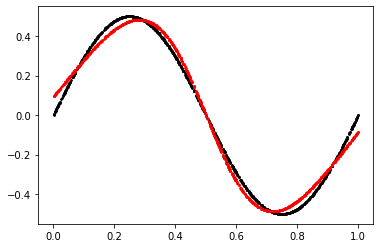

In [ ]:
# Test: plot the model approximation and the actual function f
x = tf.random.uniform((1000, 1, 1), minval=0.0, maxval=1.0)
y = 0.5*tf.sin(x * math.pi * 2.0)
y_obs = sigmoidModel(x)
plt.scatter(x, y, c="black", s=3)
plt.scatter(x, y_obs, c="red", s=3)
plt.show()

In [ ]:
# Train the model
sigmoidModel.fit(x, y, epochs=1000, batch_size=100, verbose=0)

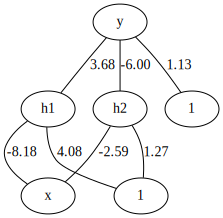

In [ ]:
# Plot the network
g = gv.Graph()
g.edge("y", "h2", "%.2f" % float(sigmoidModel.w[1][1,0]))
g.edge("y", "h1", "%.2f" % float(sigmoidModel.w[1][0,0]))
g.edge("y", "1 ", "%.2f" % float(sigmoidModel.b[1][0,0]))

g.edge("h1", "x", "%.2f" % float(sigmoidModel.w[0][0,0]))
g.edge("h2", "x", "%.2f" % float(sigmoidModel.w[0][0,1]))
g.edge("h1", "1", "%.2f" % float(sigmoidModel.b[0][0,0]))
g.edge("h2", "1", "%.2f" % float(sigmoidModel.b[0][0,1]))
g

In [ ]:
tf.matmul(tf.nn.sigmoid(tf.matmul(tf.constant([[0.5]]), sigmoidModel.w[0]) + sigmoidModel.b[0]), sigmoidModel.w[1]) + sigmoidModel.b[1]

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.748565]], dtype=float32)>

---

# Approximating an Arbitrary Function using Convolution

This section describes a neural network configuration that can approximate a real-valued function $\mathbb{R} \rightarrow \mathbb{R}$ on a certain domain. The structure is inspired by signal convolution in linear systems, but it is also reminiscent of a fuzzy logic system. [Theory and Method](#scrollTo=pgvQywdywT27) describes the mathematical principles and [Implementation](#scrollTo=x5qhSvWBw4bI) provides code for exploration and testing.


## Theory and Method

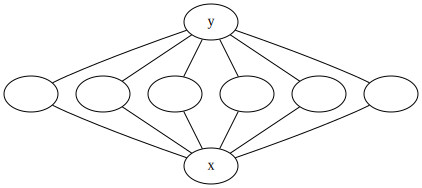

In [ ]:
g = gv.Graph()
g.node_attr["label"] = ""
g.node("i", "x")
g.node("o", "y")
g.edges(["oa", "ob", "oc", "od", "oe", "of"])
g.edges(["ai", "bi", "ci", "di", "ei", "fi"])
g

The network has one input node, one output node, and one hidden layer. Let $h$ denote the number of nodes in the hidden layer. The approximation becomes better as $h$ increases.

Broadly, this network approximates a function by partitioning the domain of interest into $h$ equally-sized segments. The goal for any input is to get one particular node in the hidden layer to activate while the rest are deactivated. The activated node should correspond to the segment in which the input resides. The final set of weights can then easily be tuned so that the final output corresponds to the activated node according to the function being approximated.

Intuitively, each hidden node "detects" when the input is close to a particular value. To accomplish this, an activation function $a$ should be used such that:

$$a(0) = 1$$
$$\lim_{x \rightarrow \infty} a(x) = \lim_{x \rightarrow -\infty} a(x) = 0$$

For example, a gaussian or "spike" curve will suffice. Now suppose the $i$-th hidden node needs to detect when the input is near $x_i$. Then the activation $v_i$ of that node should be:

$$ v_i = a(wx -wx_i) $$

The weight $w$ can be varied, but the bias needs to be set so that $v_i = 1$ when $x = x_i$.

If we are approximating a function $f$, then the output $y$ is given by:
$$ y = \sum_{i=1}^{h} v_i f(x_i) $$

The neural network is essentially just calculating $f$ by approximating the following equation:

$$ f(x) = \int_{a}^{b} f(\tau)\ \delta(x - \tau)\ d\tau \approx \sum_{i=1}^{h} f(i \Delta)\ r(x - i \Delta) $$

where $(a,b)$ is our domain of interest, $\Delta = (b - a)/h$, $r(0) = 1$, and $r(x) = 0$ for $x \ge h$ or $x \le -h$.

If we substitute the computation for $v_i$ into the equation for $y$, we can see the similarity:

$$ y = \sum_{i=1}^{h} f(x_i)\ a(wx - wx_i)$$

If we let $x_i = i\Delta$ and $a(wt) = r(t)$, then the correspondence becomes complete.

$$ y = \sum_{i=1}^{h} f(i\Delta)\ a(w \cdot (x - i\Delta))$$

## Implementation

Currently, the function being approximated is $0.5 \sin(\pi x)$. Change [this cell](#scrollTo=AKMcQ9OXEPdR) if you want to approximate a different function.

[This cell](#scrollTo=zXPo8b9yndcO) manually sets the weights and biases of the network to the values prescribed by the theory. These are not guarenteed to be the best values (training the network afterwards does give improvements), but gives a good starting point.

If the weights and biases are randomly initialized, the network probably won't learn on its own to use this approximation method. It just serves as a demonstration of how a network with one hidden layer could theoretically learn any real valued function.

In [ ]:
# Constructs a new model called "sinModel"
# MyModel(h) constructs the 3-layer network described above with h
# nodes in the hidden layer.
class MyModel(tf.keras.Model):
  def __init__(self, h, **kwargs):
    super().__init__(**kwargs)
    #self.a = lambda x: tf.exp(-x**2)   # the gaussian activation function
    self.a = lambda x: tf.maximum(1-tf.abs(x), 0)  # sawtooth activation
    self.w1 = tf.Variable(tf.random.uniform(shape=[1, h]))
    self.b1 = tf.Variable(tf.random.uniform(shape=[1, h]))
    self.w2 = tf.Variable(tf.random.uniform(shape=[h, 1]))
    self.b2 = tf.Variable(tf.random.uniform(shape=[1, 1]))
  def hl_act(self, i, x, **kwargs):
    w1 = tf.reshape(self.w1[0,i], [1, 1])
    b1 = tf.reshape(self.b1[0,i], [1, 1])
    return self.a(tf.matmul(x, w1) + b1)
  def __call__(self, x, **kwargs):
    hiddenlayer = self.a(tf.matmul(x, self.w1) + self.b1)
    return tf.matmul(hiddenlayer, self.w2) + self.b2

sinModel = MyModel(6)

In [ ]:
# The function we want to approximate.
# In this case, 0.5sin(pi*x)
def f(x):
  return 0.5 * tf.sin(math.pi * x)

In [ ]:
# Manually set the weights and biases to approximate f on
# the interval [0,1]. Six sample values are used.

parts = tf.constant([[0.0, 0.2, 0.4, 0.6, 0.8, 1.0]])
w = 5.0

sinModel = MyModel(6)
sinModel.w1.assign(tf.constant([[w, w, w, w, w, w]]))
sinModel.b1.assign(parts * -w)
sinModel.w2.assign(f(tf.reshape(parts, (6, 1))))
sinModel.b2.assign(tf.zeros(shape=(1,1)))

<tf.Variable 'UnreadVariable' shape=(1, 1) dtype=float32, numpy=array([[0.]], dtype=float32)>

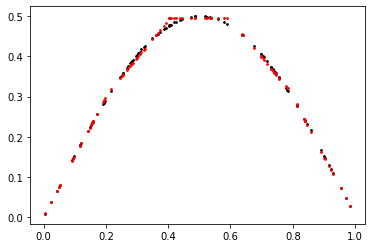

In [ ]:
# Test: plot the model approximation and the actual function f
x = tf.random.uniform((100, 1, 1), minval=0.0, maxval=1.0)
y = f(x)
y_obs = sinModel(x)
plt.scatter(x, y, c="black", s=3)
plt.scatter(x, y_obs, c="red", s=3)
plt.show()

In [ ]:
# Train the model
sinModel.compile(run_eagerly=False,
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
                loss=tf.keras.losses.mean_squared_error)
sinModel.fit(x, y, epochs=1000, batch_size=100, verbose=0)

In [ ]:
# print weights and biases
print(sinModel.w1)

<tf.Variable 'Variable:0' shape=(1, 6) dtype=float32, numpy=
array([[5.       , 4.998653 , 4.994859 , 4.9996285, 5.008215 , 5.       ]],
      dtype=float32)>


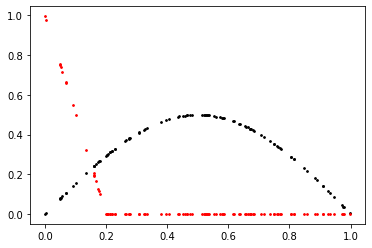

In [ ]:
# plot the activation of the 0-th hidden node
x = tf.random.uniform((100, 1, 1), minval=0.0, maxval=1.0)
y = f(x)
y_obs = sinModel.hl_act(0, x)

plt.scatter(x, y, c="black", s=3)
plt.scatter(x, y_obs, c="red", s=3)
plt.show()

## Four-Layer Version

Commonly used activation functions like sigmoid and the rectified linear don't usually tend toward zero on both ends. However, inserting another hidden layer allows us to use sigmoidal activation functions.

Broadly, the purpose of the nodes in the second hidden layer is the same as the hidden nodes in the 3-layer version: to activate when the input is close to some fixed value. The nodes in the first hidden layer should be zero, when read from left to right, until some node where the values switch to one.

Speaking of the hidden layers in terms of signals, the second hidden layer is the "derivative" of the first, and the feed-forward calculation between them can be compared to convolving the first signal with the $\delta$ signal.

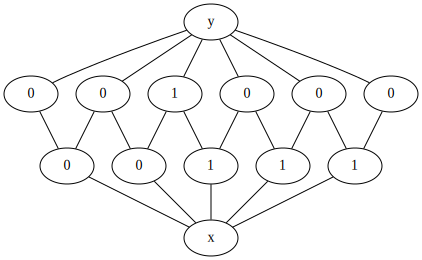

In [ ]:
g = gv.Graph()
g.node("i", "x")
g.node("o", "y")
for n in ["u", "v", "a", "b", "d", "e", "f"]: g.node(n, "0")
for n in ["w", "x", "y", "c"]: g.node(n, "1")
g.edges(["oa", "ob", "oc", "od", "oe", "of"])
g.edges(["au", "bu", "bv", "cv", "cw", "dw", "dx", "ex", "ey", "fy"])
g.edges(["ui", "vi", "wi", "xi", "yi"])
g